# Import Library

In [ ]:
!pip install toad

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
import toad
from toad.metrics import KS, AUC
from toad.plot import bin_plot, badrate_plot
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
import shap

## Load Cleaned Data

In [ ]:
from google.colab import drive
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Mount Google Drive
drive.mount('/content/drive')

# Tentukan path folder yang sesuai setelah Drive di-mount
folder_path = '/content/drive/MyDrive/data_homecredit/'

# Membaca file Parquet
df_train_full = pd.read_parquet(f'{folder_path}df_train_full.parquet')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1430155 entries, 0 to 1430154
Columns: 105 entries, SK_ID_CURR to AVERAGE_DPD
dtypes: float64(54), int64(21), object(30)
memory usage: 1.1+ GB


In [ ]:
pd.set_option('display.max_columns', None)

# Pilih kolom-kolom bertipe objek dan simpan dalam variabel 'categoric'
categoric = df_train_full.select_dtypes('object')

# Pilih kolom-kolom bertipe numerik dan simpan dalam variabel 'numeric'
numeric = df_train_full.select_dtypes('number')

# Tentukan jumlah baris dan kolom
rows = df_train_full.shape[0]
cols = df_train_full.shape[1]

# Cetak bentuk DataFrame
print(f'Jumlah Baris: {rows}\nJumlah Kolom: {cols}')

# Cetak sampel 6 baris dari DataFrame
print('\nContoh Data:')
display(df_train_full.sample(6))

# Cetak ringkasan statistik data kategorikal
print('\nRingkasan Statistik Data Kategorikal:')
display(categoric.describe().T)

# Cetak ringkasan statistik data numerik
print('\nRingkasan Statistik Data Numerik:')
display(numeric.describe().T)

# Define categorical_col and numerical_col before printing
categorical_col = categoric.columns.tolist()  # Get the list of categorical columns
numerical_col = numeric.columns.tolist()    # Get the list of numerical columns

Jumlah Baris: 1430155
Jumlah Kolom: 105

Contoh Data:


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_curr,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_curr,AMT_ANNUITY_curr,AMT_GOODS_PRICE_curr,NAME_TYPE_SUITE_curr,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START_curr,HOUR_APPR_PROCESS_START_curr,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,MEAN_BUREAU_STATUS,STATUS_BIN,AVG_DAYS_OVERDUE,DEBT_CREDIT_RATIO,SK_ID_PREV,NAME_CONTRACT_TYPE_prev,AMT_ANNUITY_prev,AMT_APPLICATION,AMT_CREDIT_prev,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE_prev,WEEKDAY_APPR_PROCESS_START_prev,HOUR_APPR_PROCESS_START_prev,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE_prev,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,AMT_INSTALMENT,AMT_PAYMENT,DIFF_INSTALLMENT_PAYMENT,AVERAGE_DPD
55027,113843,0,Revolving loans,F,N,Y,0,270000.0,202500.0,10125.0,202500.0,Unaccompanied,Working,Secondary / secondary special,Separated,House / apartment,0.019101,-20056,-2690,-2796.0,-3573,1,1,0,1,0,0,Cooking staff,1.0,2,2,MONDAY,12,0,0,0,0,0,0,Kindergarten,0.623330,0.427657,0.9816,0.1667,0.9816,0.1667,0.9816,0.1667,0.0688,No,1.0,0.0,1.0,0.0,-1941.0,0.0,0.0,0.0,0.0,2.0,5.0,1920082.320,131503.500,0.000000,heavy_late,0.0,0.068488,1997598.0,Consumer loans,11250.000,56650.500,56650.5,0.000,56650.500,WEDNESDAY,19.0,Y,1.0,0.000000,XAP,Unused offer,-1216.0,Cash through the bank,CLIENT,Unknown,Repeater,Computers,XNA,XNA,Country-wide,40.0,Connectivity,12.0,XNA,POS mobile with interest,365243.0,-831.0,-361.0,-537.0,-499.0,0.0,0.000,0.000,0.00,NaN
267420,166903,0,Cash loans,M,Y,Y,0,157500.0,256500.0,16519.5,256500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.028663,-15718,-1424,-6083.0,-4083,1,1,0,1,0,0,Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Industry: type 9,0.477684,0.357293,0.9826,0.3333,0.9826,0.3333,0.9826,0.3333,0.2212,No,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,34048.125,12679.335,1.000000,light_late,0.0,0.372395,1845118.0,Consumer loans,12386.385,103495.500,112603.5,0.000,103495.500,SATURDAY,13.0,Y,1.0,0.000000,XAP,Approved,-496.0,Cash through the bank,XAP,Unknown,Refreshed,Computers,POS,XNA,Country-wide,2300.0,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-465.0,-195.0,-195.0,-187.0,0.0,148629.915,123857.145,24772.77,0.0
449708,212432,0,Cash loans,F,N,Y,0,135000.0,1288350.0,37800.0,1125000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.022625,-19028,-6478,-3795.0,-2542,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,15,0,0,0,0,0,0,Business Entity Type 3,0.564941,0.321735,0.9935,0.1667,0.9935,0.1667,0.9935,0.1667,0.0716,No,0.0,0.0,0.0,0.0,-2522.0,0.0,0.0,0.0,5.0,0.0,0.0,5056128.000,2409471.000,0.000000,heavy_late,0.0,0.476545,2631382.0,Consumer


Ringkasan Statistik Data Kategorikal:


,count,unique,top,freq
NAME_CONTRACT_TYPE_curr,1430155,2,Cash loans,1320679
CODE_GENDER,1430155,3,F,964822
FLAG_OWN_CAR,1430155,2,N,947544
FLAG_OWN_REALTY,1430155,2,Y,1031672
NAME_TYPE_SUITE_curr,1430155,7,Unaccompanied,1171310
NAME_INCOME_TYPE,1430155,8,Working,730613
NAME_EDUCATION_TYPE,1430155,5,Secondary / secondary special,1046822
NAME_FAMILY_STATUS,1430155,6,Married,921040
NAME_HOUSING_TYPE,1430155,6,House / apartment,1279761
OCCUPATION_TYPE,1430155,18,Laborers,716492



Ringkasan Statistik Data Numerik:


,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,1430155.0,278470.247890,102802.095340,100002.0,189361.0,278956.00,367509.000,4.562550e+05
TARGET,1430155.0,0.086242,0.280722,0.0,0.0,0.00,0.000,1.000000e+00
CNT_CHILDREN,1430155.0,0.403887,0.716518,0.0,0.0,0.00,1.000,1.900000e+01
AMT_INCOME_TOTAL,1430155.0,173603.622588,198330.285287,25650.0,112500.0,157500.00,211500.000,1.170000e+08
AMT_CREDIT_curr,1430155.0,589338.592951,387420.355419,45000.0,270000.0,508495.50,808650.000,4.050000e+06
...,...,...,...,...,...,...,...,...
NFLAG_INSURED_ON_APPROVAL,1413701.0,0.199366,0.399524,0.0,0.0,0.00,0.000,1.000000e+00
AMT_INSTALMENT,1413701.0,135133.806580,280811.736748,0.0,0.0,37148.22,136007.100,1.934759e+07
AMT_PAYMENT,1413701.0,136538.978006,300142.070809,0.0,0.0,36030.42,131706.945,1.934759e+07
DIFF_INSTALLMENT_PAYMENT,1413701.0,-1405.171426,73348.780934,-3195000.0,0.0,0.00,0.000,2.602349e+06


In [ ]:
print("Categorical columns: ", categorical_col)
print("Numerical columns: ", numerical_col)

Categorical columns:  ['NAME_CONTRACT_TYPE_curr', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE_curr', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START_curr', 'ORGANIZATION_TYPE', 'EMERGENCYSTATE_MODE', 'STATUS_BIN', 'NAME_CONTRACT_TYPE_prev', 'WEEKDAY_APPR_PROCESS_START_prev', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE_prev', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION']
Numerical columns:  ['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT_curr', 'AMT_ANNUITY_curr', 'AMT_GOODS_PRICE_curr', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_C

# **EDA**

## **Check Missing Value**

In [ ]:
# Memeriksa baris duplikat
duplicate_rows = df_train_full.duplicated()

# Menampilkan jumlah baris duplikat
print(f"Jumlah baris duplikat: {duplicate_rows.sum()}")

# Fungsi untuk menghitung dan menampilkan kolom dengan nilai missing
def check_nan(df_train_full):
    # Hitung nilai null
    null_values = df_train_full.isnull().sum()

    # Buat DataFrame untuk total nilai null dan persentase
    nvc = pd.DataFrame(null_values[null_values > 0].sort_values(), columns=['Total Null Values'])  # Hanya ambil kolom dengan nilai null
    nvc['Percentage'] = (nvc['Total Null Values'] / df_train_full.shape[0]) * 100
    nvc["Data Type"] = [df_train_full[col].dtype for col in nvc.index]  # Ambil tipe data dari kolom yang ada

    # Urutkan berdasarkan total nilai null dan persentase
    nvc.sort_values(by=["Total Null Values", "Percentage"], ascending=False, inplace=True)

    # Tampilkan hasil dengan gaya
    return nvc.style.background_gradient(cmap='Blues')

# Panggil fungsi dan simpan hasilnya
styled_result = check_nan(df_train_full)

# Untuk menampilkan hasil di Jupyter Notebook, gunakan:
styled_result

Jumlah baris duplikat: 0


,Total Null Values,Percentage,Data Type
AVERAGE_DPD,660541,46.186672,float64
STATUS_BIN,175487,12.270488,object
SK_ID_PREV,16454,1.150505,float64
NAME_CONTRACT_TYPE_prev,16454,1.150505,object
AMT_ANNUITY_prev,16454,1.150505,float64
AMT_APPLICATION,16454,1.150505,float64
AMT_DOWN_PAYMENT,16454,1.150505,float64
AMT_CREDIT_prev,16454,1.150505,float64
AMT_GOODS_PRICE_prev,16454,1.150505,float64
WEEKDAY_APPR_PROCESS_START_prev,16454,1.150505,object


**Kolom AVERAGE_DPD (missing ~46%)**

* Wajar, kemungkinan karena banyak klien tidak punya riwayat keterlambatan pembayaran atau tidak punya aplikasi sebelumnya.

* Missing-nya punya makna, biarkan missing sebagai informasi.

**Kolom lain (missing <12.3%)**

* Proporsi missing rendah, biarkan missing, nanti saat WOE binning dianggap kategori khusus.

## **Handle invalid values**

In [ ]:
train_full = df_train_full
# x train categorical value binning
train_full['AGE'] = round(abs(train_full['DAYS_BIRTH'] / 365.25)).astype(int)

In [ ]:
print(train_full['AGE'].value_counts())

AGE
39    41708
40    41302
38    40703
41    39763
37    39252
44    39202
43    39164
42    39030
28    37304
32    37223
31    36987
36    36948
30    36039
45    35493
46    35001
33    34872
35    34757
54    34709
34    34562
29    34358
47    34153
57    33692
55    33498
48    33244
60    32935
53    32653
59    32366
56    31910
49    31658
52    31404
58    30819
50    30790
61    29596
51    29441
63    28123
27    27419
64    27134
62    26665
65    22938
26    17900
25    15978
66    13998
24    13756
23    11407
67     9987
68     9018
22     6086
21     1733
69     1477
Name: count, dtype: int64


In [ ]:
def age_group(age):
    if age < 30:
        return 'Young'
    elif 30 <= age <= 44:
        return 'Adult'
    elif 45 <= age <= 59:
        return 'Middle_Age'
    else:
        return 'Senior'

train_full['AGE_GROUP'] = train_full['AGE'].apply(age_group)


train_full = train_full[train_full.NAME_FAMILY_STATUS != 'Unknown']

# make a function to replace columns value contains XNA or XAP with np.nan
def replace_xna_xap(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].replace(['XNA', 'XAP'], np.nan)
    return df

train_full = replace_xna_xap(train_full)

# replace abnormal value
replace_val = {4.5 : 5,
               0.5 : 1}
train_full['CNT_FAM_MEMBERS'] = train_full['CNT_FAM_MEMBERS'].replace(replace_val)

## **Check Outlier**

In [ ]:
def get_custom_palette():
    return [
        "#2E2C36",  # Dark Gray / Charcoal
        "#701F1F",  # Dark Red / Maroon
        "#D33A2E",  # Bright Red
        "#FFFFFF",  # White
        "#F2E8DC",  # Warm Beige
        "#E3B505",  # Gold / Mustard
        "#4ECDC4",  # Teal / Soft Cyan
        "#1B9AAA",  # Deep Sky Blue
        "#FF8552",  # Soft Orange Coral
        "#2A9D8F"   # Muted Turquoise Green
    ]

In [ ]:
# Get numerical columns from the DataFrame 'df'
num_columns = train_full.select_dtypes(include=['number']).columns

# Now you can use 'num_columns' as intended
num_columns # numerical columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT_curr', 'AMT_ANNUITY_curr', 'AMT_GOODS_PRICE_curr',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START_curr',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG',
       'YEARS_BEGINEXPLUATATION_MODE', 'FLOORSMAX_MODE',
       'YEARS_BEGINEXPLUATATION_MEDI', 'FLOORSMAX_MEDI', 'TOTALAREA_MODE',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SO

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

def plot_outliers(df, num_cols, cols_per_row=4, row_height=4, col_width=5):
    total = len(num_cols)
    rows = math.ceil(total / cols_per_row)
    figsize = (col_width * cols_per_row, row_height * rows)

    plt.style.use('default')  # Background putih
    fig, axes = plt.subplots(rows, cols_per_row, figsize=figsize)
    axes = axes.flatten()

    for i, col in enumerate(num_cols):
        sns.boxplot(y=df[col], ax=axes[i], color='steelblue', linewidth=1)
        axes[i].set_title(f'{col}', fontsize=10)
        axes[i].set_ylabel('')
        axes[i].grid(True, linestyle='--', alpha=0.5)

    # Hapus subplot kosong
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle('Boxplots of Numerical Features', fontsize=14, y=1.02)
    plt.show()

In [ ]:
# # function call
# plot_outliers(train_full, num_columns)

In [ ]:
def outliers_info(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR

    count = ((series < lower_bound) | (series > upper_bound)).sum()
    return count, upper_bound, lower_bound

In [ ]:
def print_outliers(df, num_cols):
    outliers_dict = {}  # store the column name and the number of outliers present

    for col in num_cols:
        count, upper, lower = outliers_info(df[col])  # gunakan variabel baru

        if count > 0:
            outliers_dict[col] = count  # simpan hanya kolom yang punya outlier

    # Sort hasilnya dari yang paling banyak outlier
    sorted_outliers = dict(sorted(outliers_dict.items(), key=lambda item: item[1], reverse=True))

    # Tampilkan
    for col, val in sorted_outliers.items():
        print(f'Total outliers in {col}: {val} ({((val/len(df)) * 100):.2f}%)')

    print(f'\nTotal columns with outliers: {len(sorted_outliers)} out of {len(num_cols)}')

In [ ]:
print_outliers(train_full, num_columns)

Total outliers in YEARS_BEGINEXPLUATATION_MODE: 666305 (46.59%)
Total outliers in TOTALAREA_MODE: 631993 (44.19%)
Total outliers in YEARS_BEGINEXPLUATATION_MEDI: 574198 (40.15%)
Total outliers in YEARS_BEGINEXPLUATATION_AVG: 572838 (40.05%)
Total outliers in FLOORSMAX_AVG: 431562 (30.18%)
Total outliers in FLOORSMAX_MEDI: 423440 (29.61%)
Total outliers in FLOORSMAX_MODE: 414369 (28.97%)
Total outliers in DAYS_TERMINATION: 405484 (28.35%)
Total outliers in DAYS_LAST_DUE: 392253 (27.43%)
Total outliers in REGION_RATING_CLIENT: 357169 (24.97%)
Total outliers in DAYS_LAST_DUE_1ST_VERSION: 352192 (24.63%)
Total outliers in AMT_DOWN_PAYMENT: 350186 (24.49%)
Total outliers in RATE_DOWN_PAYMENT: 350186 (24.49%)
Total outliers in DAYS_EMPLOYED: 348600 (24.38%)
Total outliers in REGION_RATING_CLIENT_W_CITY: 344069 (24.06%)
Total outliers in REG_CITY_NOT_WORK_CITY: 317515 (22.20%)
Total outliers in AMT_REQ_CREDIT_BUREAU_QRT: 301237 (21.06%)
Total outliers in DAYS_FIRST_DUE: 288949 (20.20%)
Total 

In [ ]:
# Accessing categorical features
categorical_features = train_full.select_dtypes(include=['object']).columns.tolist()

print("Categorical Features in train_full:")
for col in categorical_features:
    print(col)  # This line is now properly indented

Categorical Features in train_full:
NAME_CONTRACT_TYPE_curr
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE_curr
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
OCCUPATION_TYPE
WEEKDAY_APPR_PROCESS_START_curr
ORGANIZATION_TYPE
EMERGENCYSTATE_MODE
STATUS_BIN
NAME_CONTRACT_TYPE_prev
WEEKDAY_APPR_PROCESS_START_prev
FLAG_LAST_APPL_PER_CONTRACT
NAME_CASH_LOAN_PURPOSE
NAME_CONTRACT_STATUS
NAME_PAYMENT_TYPE
CODE_REJECT_REASON
NAME_TYPE_SUITE_prev
NAME_CLIENT_TYPE
NAME_GOODS_CATEGORY
NAME_PORTFOLIO
NAME_PRODUCT_TYPE
CHANNEL_TYPE
NAME_SELLER_INDUSTRY
NAME_YIELD_GROUP
PRODUCT_COMBINATION
AGE_GROUP


# **Business Insight**

In [ ]:
# def get_custom_palette():
#     return [
#         "#2E2C36",  # Dark Gray / Charcoal
#         "#701F1F",  # Dark Red / Maroon
#         "#D33A2E",  # Bright Red
#         "#FFFFFF",  # White
#         "#F2E8DC",  # Warm Beige
#         "#E3B505",  # Gold / Mustard
#         "#4ECDC4",  # Teal / Soft Cyan
#         "#1B9AAA",  # Deep Sky Blue
#         "#FF8552",  # Soft Orange Coral
#         "#2A9D8F"   # Muted Turquoise Green
#     ]

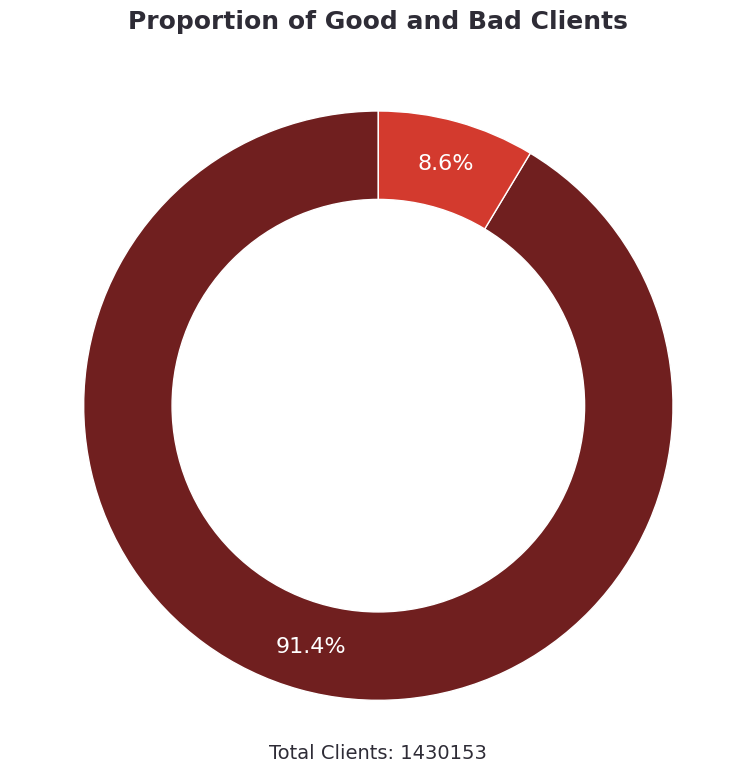

In [ ]:
# Ambil palet
palette = get_custom_palette()

# Data
counts = train_full['TARGET'].value_counts(normalize=True)
labels = ['Good Clients', 'Bad Clients']

# Gunakan warna dari palet (misalnya: Good = Teal, Bad = Dark Red)
colors = [palette[1], palette[2]]  # Teal / Soft Cyan dan Dark Red / Maroon

# Pie chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    counts,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85,
    textprops={'color': 'white', 'fontsize': 16}
)

# Donut hole
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Title dan informasi total
plt.title('Proportion of Good and Bad Clients', fontsize=18, fontweight='bold', color=palette[0])
plt.text(0, -1.2, f"Total Clients: {train_full.shape[0]}", fontsize=14, ha='center', color=palette[0])

plt.tight_layout()
plt.show()

In [ ]:
good_clients = train_full[train_full['TARGET'] == 0].shape[0]
bad_clients = train_full[train_full['TARGET'] == 1].shape[0]

print(f"Number of good clients: {good_clients}")
print(f"Number of bad clients: {bad_clients}")


Number of good clients: 1306813
Number of bad clients: 123340



🎯 Korelasi tertinggi (numerik) ke TARGET:
EXT_SOURCE_3                  -0.167307
EXT_SOURCE_2                  -0.155090
AGE                           -0.074381
DAYS_BIRTH                     0.074314
REGION_RATING_CLIENT_W_CITY    0.059832
Name: TARGET, dtype: float64


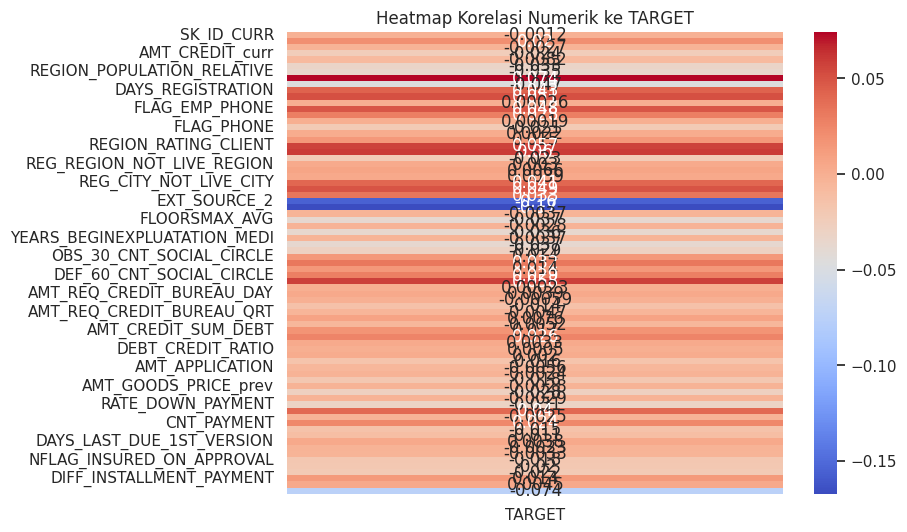

In [ ]:
# 1️⃣ Fitur numerik: cari korelasi Pearson ke target
# -----------------------------
num_columns = train_full.select_dtypes(include=['number']).columns.tolist()

# Pastikan TARGET ada di dataframe
if 'TARGET' not in train_full.columns:
    raise ValueError('Kolom TARGET tidak ditemukan di dataframe')

corr_matrix = train_full[num_columns].corr()
corr_target = corr_matrix['TARGET'].drop('TARGET').sort_values(key=abs, ascending=False)

print("\n🎯 Korelasi tertinggi (numerik) ke TARGET:")
print(corr_target.head(5))

# Visualisasi heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix[['TARGET']].drop('TARGET'), annot=True, cmap='coolwarm')
plt.title('Heatmap Korelasi Numerik ke TARGET')
plt.show()

# Ambil fitur numerik korelasi tertinggi
top_numeric = corr_target.index[0]

In [ ]:
from scipy.stats import chi2_contingency
# 2️⃣ Fitur kategorikal: cari asosiasi Cramér's V ke target
# -----------------------------
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

categorical_features = [
    'NAME_CONTRACT_TYPE_curr', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
    'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'AGE_GROUP'
]

cramers_results = {}
for cat in categorical_features:
    val = cramers_v(train_full[cat], train_full['TARGET'])
    cramers_results[cat] = val

sorted_categorical = sorted(cramers_results.items(), key=lambda x: x[1], reverse=True)

print("\n🎯 Cramér's V tertinggi (kategorikal) ke TARGET:")
for k, v in sorted_categorical[:5]:
    print(f"{k}: {v:.4f}")

# Ambil fitur kategorikal asosiasi tertinggi
top_categorical = sorted_categorical[0][0]


🎯 Cramér's V tertinggi (kategorikal) ke TARGET:
AGE_GROUP: 0.0691
NAME_INCOME_TYPE: 0.0663
OCCUPATION_TYPE: 0.0596
ORGANIZATION_TYPE: 0.0577
CODE_GENDER: 0.0524


In [ ]:
print(train_full['NAME_INCOME_TYPE'].unique())

['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']


In [ ]:
print(train_full['OCCUPATION_TYPE'].unique())

['Laborers' 'Core staff' 'Accountants' 'Managers' 'Drivers' 'Sales staff'
 'Cleaning staff' 'Cooking staff' 'Private service staff' 'Medicine staff'
 'Security staff' 'High skill tech staff' 'Waiters/barmen staff'
 'Low-skill Laborers' 'Realty agents' 'Secretaries' 'IT staff' 'HR staff']


In [ ]:
print(train_full['ORGANIZATION_TYPE'].unique())

['Business Entity Type 3' 'School' 'Government' 'Religion' 'Other' nan
 'Electricity' 'Medicine' 'Business Entity Type 2' 'Self-employed'
 'Transport: type 2' 'Construction' 'Housing' 'Kindergarten'
 'Trade: type 7' 'Industry: type 11' 'Military' 'Services'
 'Security Ministries' 'Transport: type 4' 'Industry: type 1' 'Emergency'
 'Security' 'Trade: type 2' 'University' 'Transport: type 3' 'Police'
 'Business Entity Type 1' 'Postal' 'Industry: type 4' 'Agriculture'
 'Restaurant' 'Culture' 'Hotel' 'Industry: type 7' 'Trade: type 3'
 'Industry: type 3' 'Bank' 'Industry: type 9' 'Insurance' 'Trade: type 6'
 'Industry: type 2' 'Transport: type 1' 'Industry: type 12' 'Mobile'
 'Trade: type 1' 'Industry: type 5' 'Industry: type 10' 'Legal Services'
 'Advertising' 'Trade: type 5' 'Cleaning' 'Industry: type 13'
 'Trade: type 4' 'Telecom' 'Industry: type 8' 'Realtor' 'Industry: type 6']


### **Default Rate by Ext Source**

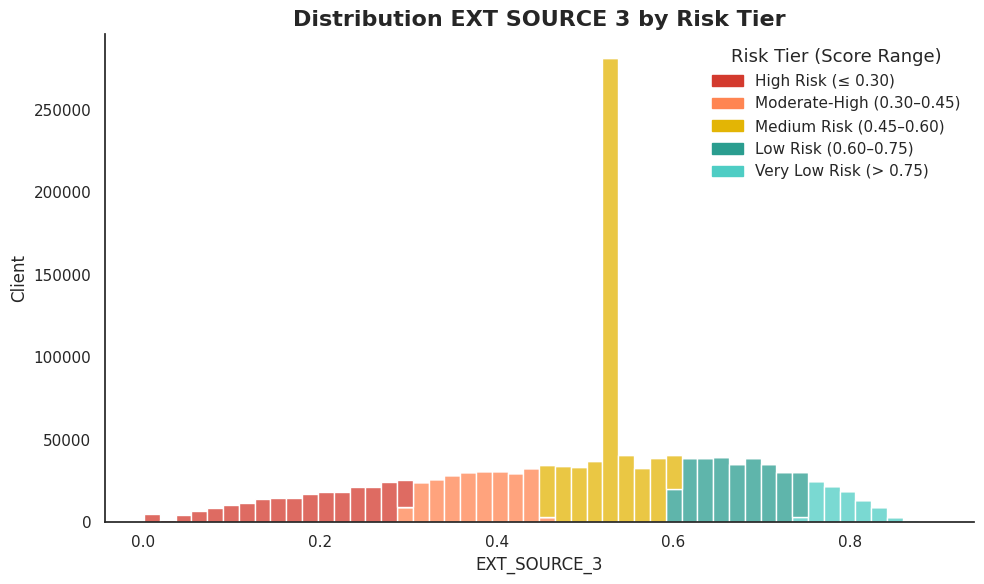

In [ ]:
from matplotlib.patches import Patch

sns.set_style("white")

# Fungsi pembagian risk tier
def assign_risk_tier(score):
    if score <= 0.30:
        return 'High Risk'
    elif score <= 0.45:
        return 'Moderate-High'
    elif score <= 0.60:
        return 'Medium Risk'
    elif score <= 0.75:
        return 'Low Risk'
    else:
        return 'Very Low Risk'

# Terapkan tier
train_full['EXT_SOURCE_3_Tier'] = train_full['EXT_SOURCE_3'].apply(assign_risk_tier)

# Ambil warna
palette_source = get_custom_palette()
palette = {
    'High Risk': palette_source[2],        # Bright Red
    'Moderate-High': palette_source[8],    # Soft Orange Coral
    'Medium Risk': palette_source[5],      # Gold / Mustard
    'Low Risk': palette_source[9],         # Muted Turquoise Green
    'Very Low Risk': palette_source[6]     # Teal / Soft Cyan
}

# Buat patch legend manual
legend_patches = [
    Patch(color=palette['High Risk'], label='High Risk (≤ 0.30)'),
    Patch(color=palette['Moderate-High'], label='Moderate-High (0.30–0.45)'),
    Patch(color=palette['Medium Risk'], label='Medium Risk (0.45–0.60)'),
    Patch(color=palette['Low Risk'], label='Low Risk (0.60–0.75)'),
    Patch(color=palette['Very Low Risk'], label='Very Low Risk (> 0.75)')
]

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(
    data=train_full,
    x='EXT_SOURCE_3',
    hue='EXT_SOURCE_3_Tier',
    bins=50,
    palette=palette,
    multiple='stack',
    kde=False
)

# Judul & label
plt.title('Distribution EXT SOURCE 3 by Risk Tier', fontsize=16, weight='bold')
plt.xlabel('EXT_SOURCE_3')
plt.ylabel('Client')

# Tambahkan legend manual
plt.legend(
    handles=legend_patches,
    title='Risk Tier (Score Range)',
    title_fontsize=13,
    fontsize=11,
    loc='upper right',
    frameon=False
)

# Hilangkan grid dan garis atas/kanan
plt.grid(False)
sns.despine(top=True, right=True)

plt.tight_layout()
plt.show()



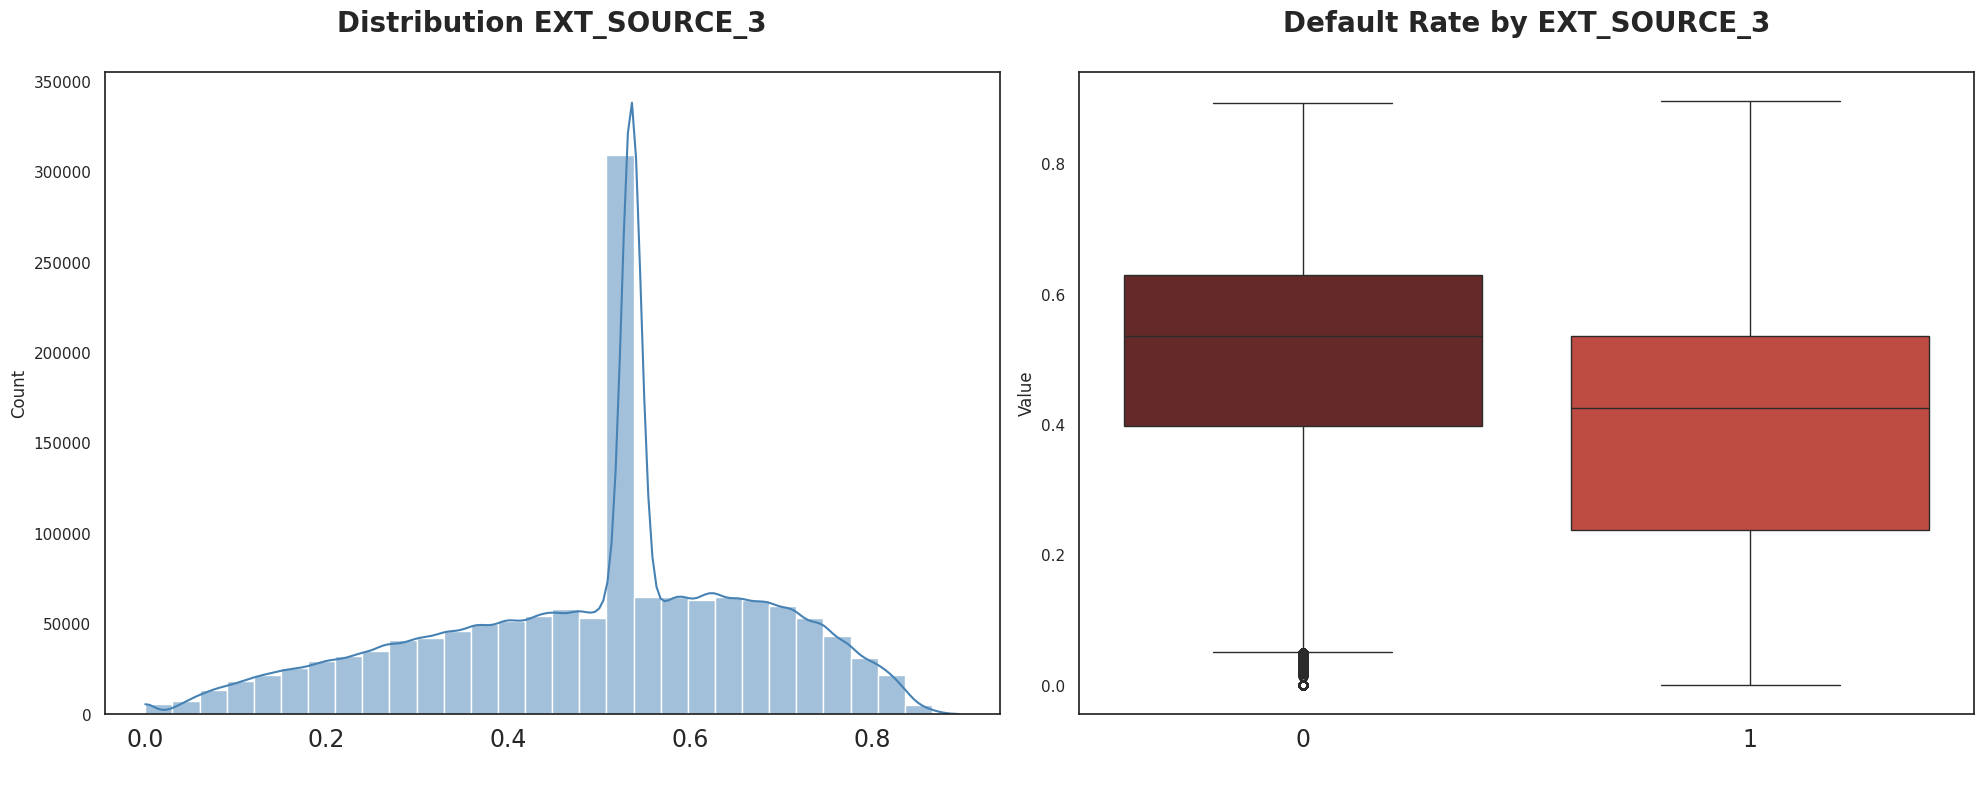

In [ ]:
# Get the top numeric feature with the highest correlation to TARGET

# Plotting
fig = plt.figure(figsize=(20, 8))
fig.patch.set_facecolor('#FFFFFF')

# First subplot: Distribution of top numeric feature (countplot style)
ax1 = plt.subplot(1, 2, 1)
ax1.set_facecolor('#FFFFFF')
sns.histplot(train_full[top_numeric], bins=30, kde=True, color='steelblue', ax=ax1)
plt.grid(False)
plt.title(f'Distribution {top_numeric}', fontsize=20, fontweight='bold', y=1.05)
plt.xlabel(' ')
plt.ylabel('Count')
plt.xticks(rotation=0, fontsize=17)

custom_palette = get_custom_palette()
target_palette = [custom_palette[1], custom_palette[2]]  # 0 = greenish, 1 = red

# Second subplot: Boxplot by TARGET with custom palette
ax2 = plt.subplot(1, 2, 2)
ax2.set_facecolor('#FFFFFF')

sns.boxplot(
    x='TARGET',
    y=top_numeric,
    data=train_full,
    palette=target_palette,
    ax=ax2
)

plt.grid(False)
plt.title(f'Default Rate by {top_numeric}', fontsize=20, fontweight='bold', y=1.05)
plt.xlabel(' ')
plt.ylabel('Value')
plt.xticks(rotation=0, fontsize=17)

plt.tight_layout()
plt.show()


### **Default Rate by Age Group**

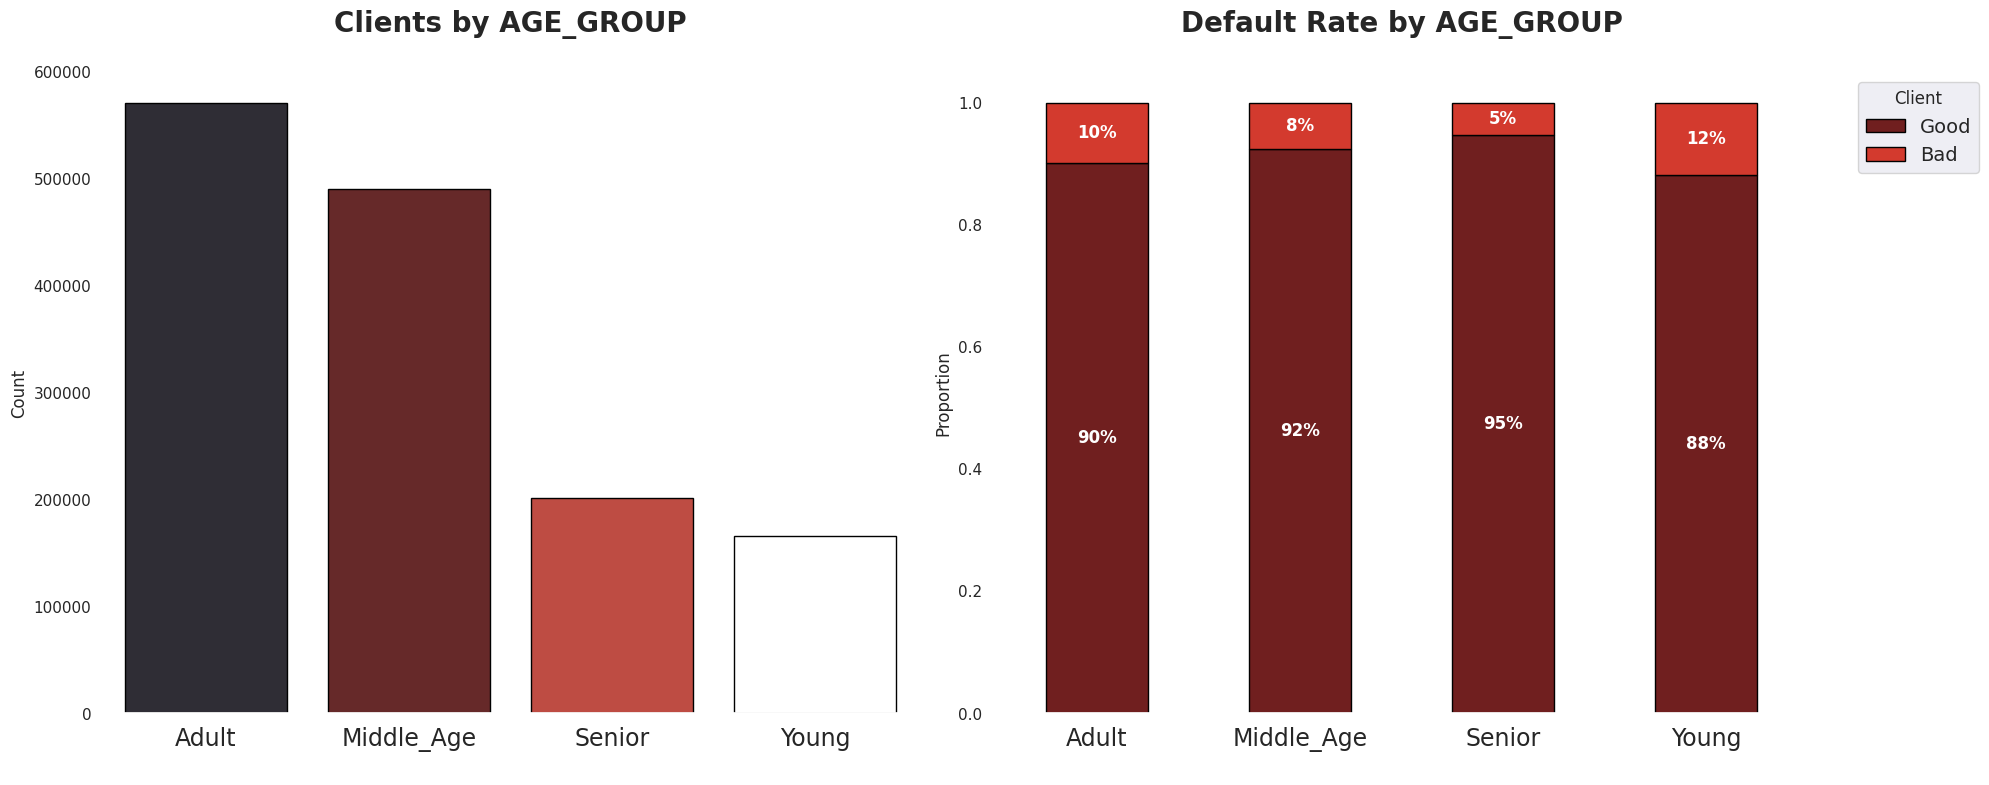

In [ ]:
# Gunakan palet kustom
custom_palette = get_custom_palette()

# Plotting
fig = plt.figure(figsize=(20, 8))
fig.patch.set_facecolor('#FFFFFF')

# First subplot: Count of top categorical feature (countplot style)
ax1 = plt.subplot(1, 2, 1)
ax1.set_facecolor('#FFFFFF')
sns.countplot(
    x=top_categorical,
    data=train_full,
    order=train_full[top_categorical].value_counts().index,
    ax=ax1,
    palette=custom_palette,  # gunakan palet kustom
    edgecolor='black'
)
plt.grid(False)
plt.title(f'Clients by {top_categorical}', fontsize=20, fontweight='bold', y=1.05)
plt.xlabel(' ')
plt.ylabel('Count')
plt.xticks(rotation=0, fontsize=17)

# Second subplot: Proportion of TARGET by categorical feature (stacked bar plot)
ax2 = plt.subplot(1, 2, 2)
ax2.set_facecolor('#FFFFFF')
cat_target = train_full.groupby(top_categorical)['TARGET'].value_counts(normalize=True).unstack()

# Hitung jumlah kategori
cat_counts = train_full[top_categorical].value_counts()

# Urutkan cat_target berdasarkan jumlah kategori
cat_target = cat_target.loc[cat_counts.index]

# Gunakan warna dari palet untuk "Good" dan "Bad"
colors = [custom_palette[1], custom_palette[2]]  # Misalnya Teal dan Bright Red

cat_target.plot(kind='bar', stacked=True, color=colors, ax=ax2, edgecolor='black')

# Tambahkan anotasi persentase dengan font warna putih
for p in ax2.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax2.annotate(
        f'{height:.0%}',
        (x + width/2, y + height/2),
        ha='center',
        va='center',
        color='white',  # font warna putih
        fontsize=12,    # opsional: ukuran font
        fontweight='bold'  # opsional: biar lebih tegas
    )

sns.despine()
plt.title(f'Default Rate by {top_categorical}', fontsize=20, fontweight='bold', y=1.05)
plt.xlabel(' ')
plt.ylabel('Proportion')
plt.xticks(rotation=0, fontsize=17)
plt.grid(False)
plt.legend(title='Client', bbox_to_anchor=(1.05, 1), fontsize=14, labels=['Good', 'Bad'])

plt.tight_layout()
plt.show()

### **Default Rate by Organization Types**

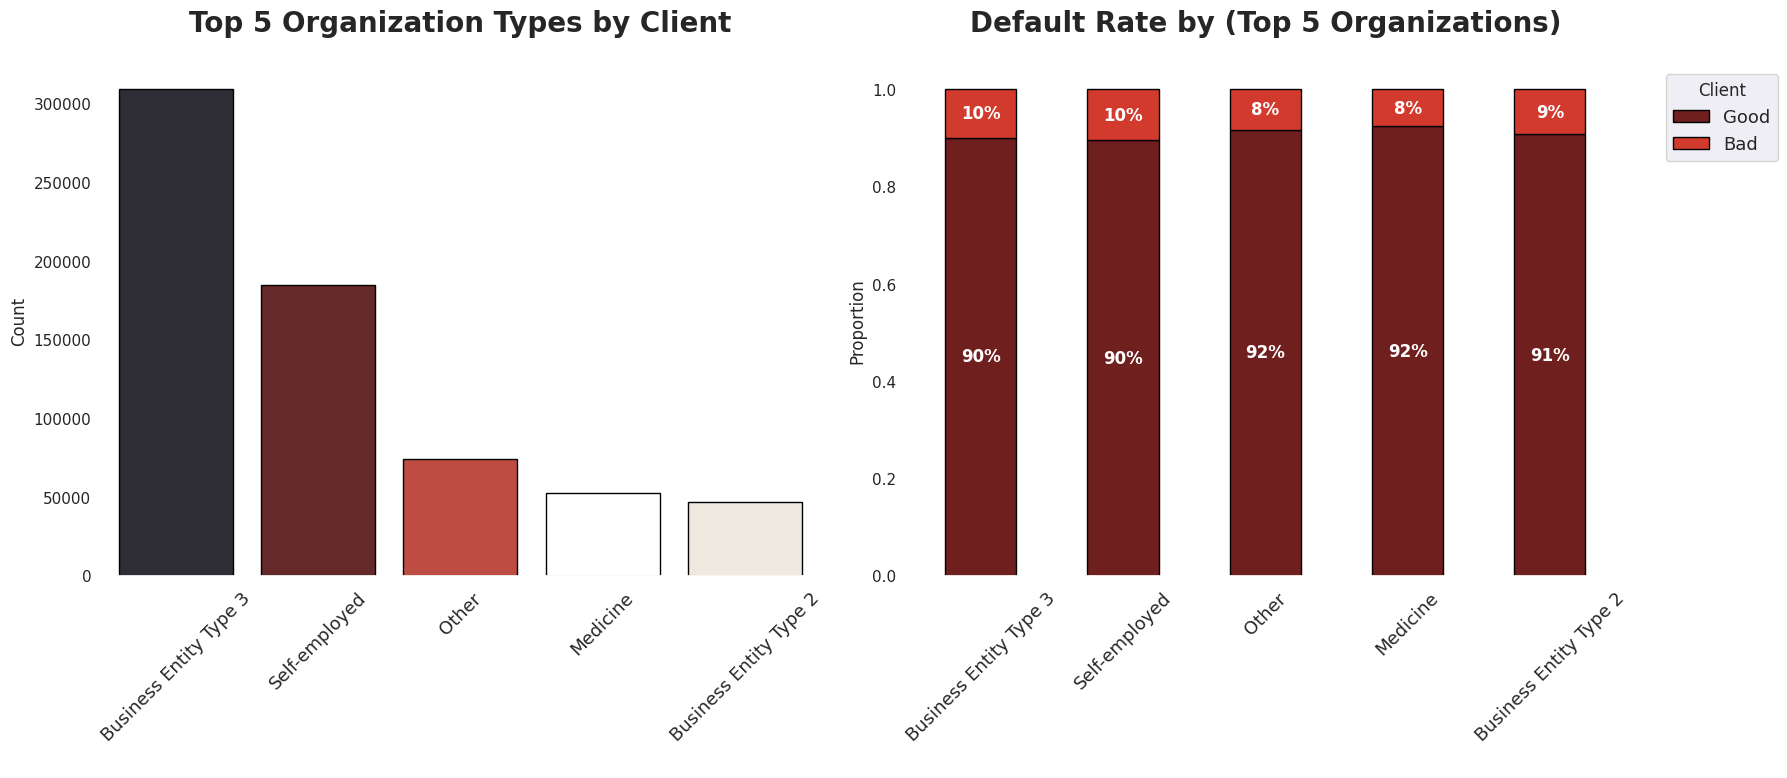

In [ ]:
# Gunakan palet kustom
custom_palette = get_custom_palette()

# Top categorical feature: ORGANIZATION_TYPE (ambil top 5)
top_categorical = 'ORGANIZATION_TYPE'
top5_categories = train_full[top_categorical].value_counts().nlargest(5).index
filtered_df = train_full[train_full[top_categorical].isin(top5_categories)]

# Plotting
fig = plt.figure(figsize=(18, 8))
fig.patch.set_facecolor('#FFFFFF')

# First subplot: Countplot untuk top 5 ORGANIZATION_TYPE
ax1 = plt.subplot(1, 2, 1)
ax1.set_facecolor('#FFFFFF')
sns.countplot(
    x=top_categorical,
    data=filtered_df,
    order=top5_categories,
    ax=ax1,
    palette=custom_palette,
    edgecolor='black'
)
plt.grid(False)
plt.title('Top 5 Organization Types by Client', fontsize=20, fontweight='bold', y=1.05)
plt.xlabel(' ')
plt.ylabel('Count')
plt.xticks(rotation=45, fontsize=13)

# Second subplot: Stacked bar plot proportion TARGET
ax2 = plt.subplot(1, 2, 2)
ax2.set_facecolor('#FFFFFF')

cat_target = filtered_df.groupby(top_categorical)['TARGET'].value_counts(normalize=True).unstack()
cat_counts = filtered_df[top_categorical].value_counts()
cat_target = cat_target.loc[cat_counts.index]

# Warna untuk Good dan Bad Clients
colors = [custom_palette[1], custom_palette[2]]  # Teal dan Bright Red

cat_target.plot(kind='bar', stacked=True, color=colors, ax=ax2, edgecolor='black')

# Anotasi persentase dengan font putih
for p in ax2.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax2.annotate(
        f'{height:.0%}',
        (x + width/2, y + height/2),
        ha='center',
        va='center',
        color='white',
        fontsize=12,
        fontweight='bold'
    )

sns.despine()
plt.title('Default Rate by (Top 5 Organizations)', fontsize=20, fontweight='bold', y=1.05)
plt.xlabel(' ')
plt.ylabel('Proportion')
plt.xticks(rotation=45, fontsize=13)
plt.grid(False)
plt.legend(title='Client', bbox_to_anchor=(1.05, 1), fontsize=13, labels=['Good', 'Bad'])

plt.tight_layout()
plt.show()

In [ ]:
train_full[train_full['ORGANIZATION_TYPE'].isin(['Business Entity Type 2', 'Business Entity Type 3'])] \
    .groupby('ORGANIZATION_TYPE') \
    .agg({
        'AMT_INCOME_TOTAL': ['mean', 'median'],
        'AGE': ['mean'],
        'TARGET': 'mean'
    })

AMT_INCOME_TOTAL                  AGE    TARGET
                                   mean    median       mean      mean
ORGANIZATION_TYPE                                                     
Business Entity Type 2    173928.169900  157500.0  41.223546  0.092354
Business Entity Type 3    193118.496977  171000.0  40.300507  0.099162

* Type 3 kemungkinan mewakili badan usaha dengan profil lebih agresif: penghasilan lebih besar, tapi sedikit lebih berisiko.

* Type 2 mungkin lebih stabil dan konservatif: pendapatan lebih rendah tapi risiko lebih kecil.

In [ ]:
train_full.to_parquet(
    'train_full.parquet',
    engine='pyarrow',
    index=False,
    compression='snappy'  # Kompresi cepat & umum, tetap jaga presisi
)

In [ ]:
train_loaded = pd.read_parquet('train_full.parquet', engine='pyarrow')
print(train_loaded.dtypes.equals(train_full.dtypes))  # Harus True
print(train_loaded.equals(train_full))                # Harus True jika semua data identik

True
False
